# Workbook for studying dark matter phase space in a specific snapshot from Elena's Trojans paper.

In [ ]:
# %matplotlib inline

In [2]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import h5py, pylab, struct
import matplotlib.cm as cm
import conversions as co
import pandas as pd

#### TODO:
* PLOTS in grids

#### Aspirations:
* Wrap the hdf5 reader such that it can read in chunks at a time

#### Notes:
* snap hdf5 structure: f has keys 'Header', 'PartType1,2,3'
* PartTypes have no attrs, keys = "Coordinates", "ParticleIDs", "Velocities" with no attrs
    * Coords and Vels are ndarrays len == 3
    * PT1=DM (20mil x 3), PT2=disk (8mil x 3), PT3=bulge (2.8mil x 3)
* header has attributes with value == 0: 
    * BoxSize, OmegaLambda, Redshift
    * Flag_[Cooling, DoublePrecision, Feedback, IC_Info, Metals, Sfr, StellarAge]
* nonzero attrs: 
    * HubbleParam, Omega0 == 1, Time (in years / 10^9 (????))
    * NumPart_ThisFile == NumPart_Total (array len 6), MassTable (array len 6)

In [3]:
def read_hdf5(path, p_type=1):
    """types: 1=DM, 2=disk, 3=bulge"""
    groups = ["Header", "PartType1", "PartType2", "PartType3"]
    head = {}
    
    f = h5py.File(path, "r")
    h = f["Header"]
    keys = list(h.attrs)
    for key in keys:
        head[key] = h.attrs[key]
    parts = f[groups[p_type]]
    columns = ["x","y","z", "vx", "vy", "vz"]
    df = pd.DataFrame(np.concatenate((parts["Coordinates"], parts["Velocities"]), axis=1),
                     columns=columns, index=parts["ParticleIDs"][:])
    f.close()
    
    return head, df

def df_center(df):
    """Centers a data frame's x,y,z keys by subtracting the median."""
    idxs = ['x', 'y', 'z']
    for idx in idxs:
        df[idx] -= df[idx].median()
        
def df_polar(df):
    """Adds in r and phi coordinates, as well as their velocities.
    Phi is the physics spherical phi, i.e. the polar theta."""
    df['r'] = np.sqrt(df['x'] ** 2 + df['y'] ** 2)
    df['phi'] = np.arctan2(df['y'], df['x'])
    # (x xdot + y ydot) / (sqrt(x^2 + y^2))
    df['vr'] = (df['x'] * df['vx'] + df['y'] * df['vy']) / df['r']
    # (x ydot - y xdot) / (x^2 + y^2)
    df['vphi'] = (df['x'] * df['vy'] - df['y'] * df['vx']) / (df['r'] ** 2)

In [4]:
def df_filter(df, key, low=None, high=None, f=None):
    """Filters a dataframe by key, greater than low, less than high,
    optionally applying function f to the data comparison."""
    if low is None and high is None:
        print("No filtering done")
        return df
    elif low is not None and high is not None:
        if f is None:
            return df[(df[key] > low) & (df[key] < high)]
        else:
            return df[(f(df[key]) > low) & (f(df[key]) < high)]
    elif low is not None:
        if f is None:
            return df[df[key] > low]
        else:
            return df[f(df[key]) > low]
    elif high is not None:
        if f is None:
            return df[df[key] < high]
        else:
            return df[f(df[key]) < high]
    else:
        print("Nani?")
        return df

In [5]:
def plot_cuts(df, ztup, rtup, phitup, bins=[100,100], vels=None, save=False, path='analysis/'):
    """NOTE: phi values from the tuple will be in degrees.
    vels is a string of comma separated velocity keys (from the dataframe)
    to be plotted, x vs y, for example, 'vphi, vr' or 'vphi, vz' """
    zlow, zhigh = ztup
    rlow, rhigh = rtup
    philow, phihigh = phitup
    dff = df_filter(df, 'z', low=zlow, high=zhigh)
    dff = df_filter(dff, 'r', low=rlow, high=rhigh)
    dff = df_filter(dff, 'phi', low=philow*np.pi/180, high=phihigh*np.pi/180)
    ti_tup = (zlow, zhigh, rlow, rhigh, philow, phihigh)
    title = "Snap cut between Z:{}-{}kpc, R:{}-{}kpc, PHI={}-{} degrees".format(*ti_tup)
    fig = plt.figure()
    plt.title(title)
    if vels is None: #plot positions
        plt.xlabel('X distance (kpc)')
        plt.ylabel('Y distance (kpc)')
        plt.hist2d(dff['x'], dff['y'], bins=bins, density=True)
        pathadd = 'surfacedensity_'
        if save:
            end = "Z{}-{}_R{}-{}_PH{}-{}".format(*ti_tup)
            plt.savefig(path + pathadd + end + ".png", dpi=300)
    elif vels is not None: #plot kinematics
        assert type(vels) is str
        keys = [v.strip() for v in vels.split(',')]
        plt.xlabel('{} (km/s)'.format(keys[0]))
        plt.ylabel('{} (km/s)'.format(keys[1]))
        plt.hist2d(dff[keys[0]], dff[keys[1]], bins=bins, density=True)
        pathadd = 'kinematics_'
        if save:
            end = "Z{}-{}_R{}-{}_PH{}-{}".format(*ti_tup)
            plt.savefig(path + pathadd + keys[0] + keys[1] + '_' + end + ".png", dpi=300)

In [6]:
def multiplot_cuts(df, ztup_l, rtup_l, phitup_l, bins=[100,100], vels=None, save=False, path='analysis/'):
    """Similar to previous plot_cuts but will subplot to one plot per z slice.
    NOTE: phi values from the tuple will be in degrees.
    vels is a string of comma separated velocity keys (from the dataframe)
    to be plotted, x vs y, for example, 'vphi, vr' or 'vphi, vz' """
    for i in range(len(ztup_l)):
        zlow, zhigh = ztup_l[i]
        figw, figh = 6.4 * len(phitup_l), 4.8 * len(rtup_l) #make figure size scale
        fig, ax = plt.subplots(len(rtup_l), len(phitup_l), figsize=[figw,figh], squeeze=False)
        save_tup = (ztup_l[i][0], ztup_l[i][1], rtup_l[0][0], rtup_l[-1][1],
                    phitup_l[0][0], phitup_l[-1][1]) #save filename
        if vels is None:
            #TODO: have one X and Y axis title label
            #fig.xlabel('X distance (kpc)')
            #fig.ylabel('Y distance (kpc)')
            pathadd = 'surfacedensity_'
        elif vels is not None:
            assert type(vels) is str
            keys = [v.strip() for v in vels.split(',')]
            #TODO: have one X and Y axis title label
            #fig.xlabel('{} (km/s)'.format(keys[0]))
            #fig.ylabel('{} (km/s)'.format(keys[1]))
            pathadd = 'kinematics_'
        
        for j in range(len(rtup_l)):
            rlow, rhigh = rtup_l[j]
            
            for k in range(len(phitup_l)):
                philow, phihigh = phitup_l[k]
                dff = df_filter(df, 'z', low=zlow, high=zhigh)
                dff = df_filter(dff, 'r', low=rlow, high=rhigh)
                dff = df_filter(dff, 'phi', low=philow*np.pi/180, high=phihigh*np.pi/180)
                ti_tup = (zlow, zhigh, rlow, rhigh, philow, phihigh)
                title = "Z:{}-{}kpc, R:{}-{}kpc, PHI={}-{}deg".format(*ti_tup)
                ax[j,k].set_title(title)
                if vels is None: #plot positions
                    ax[j,k].hist2d(dff['x'], dff['y'], bins=bins, density=True)
                    ax[j,k].set_xlabel('X distance (kpc)')
                    ax[j,k].set_ylabel('Y distance (kpc)')
                elif vels is not None: #plot kinematics
                    ax[j,k].set_xlabel('{} (km/s)'.format(keys[0]))
                    ax[j,k].set_ylabel('{} (km/s)'.format(keys[1]))
                    ax[j,k].hist2d(dff[keys[0]], dff[keys[1]], bins=bins, density=True)
                    
        #back to outer z loop
        fig.subplots_adjust(hspace=0.25, wspace=0.25)
        if save and vels is None:
            end = "Z{}-{}_R{}-{}_PH{}-{}".format(*save_tup)
            name = path + pathadd + end + ".png"
            print('saving file: ' + name)
            fig.savefig(name, dpi=300)
        elif save and vels is not None:
            end = "Z{}-{}_R{}-{}_PH{}-{}".format(*save_tup)
            name = path + pathadd + keys[0] + keys[1] + '_' + end + ".png"
            print('saving file: ' + name)
            fig.savefig(name, dpi=300)

In [7]:
def gen_plots(df, *tups, vels=None, path="analysis/", multi=True, plot=True, save=True, bins=[100,100]):
    """Generates plots using either the above plot_cuts or multiplots function
    with the given dataframe and tuples for a given coordinate with 
    (start, stop, step, key) as input tuples."""
    assert df is not None
    params = {'z':[(-10,10)], 'r':[(0,15)], 'phi':[(-180,180)]}
    #default values^^
    for tup in tups:
        start, stop, step, key = tup
        lst = []
        while start < stop:
            if start + step > stop:
                lst.append((start, stop))
                break
            lst.append((start, start+step))
            start += step
        params[key] = lst
    if plot:
        print('starting plotting')
        if multi:
            multiplot_cuts(df, params['z'], params['r'], params['phi'],
                           vels=vels, save=save, path=path, bins=bins)
        elif not multi:
            for z in params['z']:
                for r in params['r']:
                    for phi in params['phi']:
                        print('.', end='')
                        plot_cuts(df, z, r, phi, vels=vels, save=save, path=path,
                                  bins=bins)
        print('done')
    elif not plot:
        return params

#### Testing

In [8]:
# data reading and cleaning
path = "data/snap_582.hdf5"
head, df = read_hdf5(path, p_type=1)
df_center(df)
df_polar(df)

starting plotting
saving file: analysis/multis/kinematics_vphivr_Z0-2_R4.5-7.5_PH-60-60.png
saving file: analysis/multis/kinematics_vphivr_Z2-4_R4.5-7.5_PH-60-60.png
saving file: analysis/multis/kinematics_vphivr_Z4-6_R4.5-7.5_PH-60-60.png
done
starting plotting
saving file: analysis/multis/kinematics_vzvphi_Z0-2_R4.5-7.5_PH-60-60.png
saving file: analysis/multis/kinematics_vzvphi_Z2-4_R4.5-7.5_PH-60-60.png
saving file: analysis/multis/kinematics_vzvphi_Z4-6_R4.5-7.5_PH-60-60.png
done
starting plotting
saving file: analysis/multis/kinematics_vzvr_Z0-2_R4.5-7.5_PH-60-60.png
saving file: analysis/multis/kinematics_vzvr_Z2-4_R4.5-7.5_PH-60-60.png
saving file: analysis/multis/kinematics_vzvr_Z4-6_R4.5-7.5_PH-60-60.png
done
starting plotting
saving file: analysis/multis/surfacedensity_Z0-2_R4.5-7.5_PH-60-60.png
saving file: analysis/multis/surfacedensity_Z2-4_R4.5-7.5_PH-60-60.png
saving file: analysis/multis/surfacedensity_Z4-6_R4.5-7.5_PH-60-60.png
done


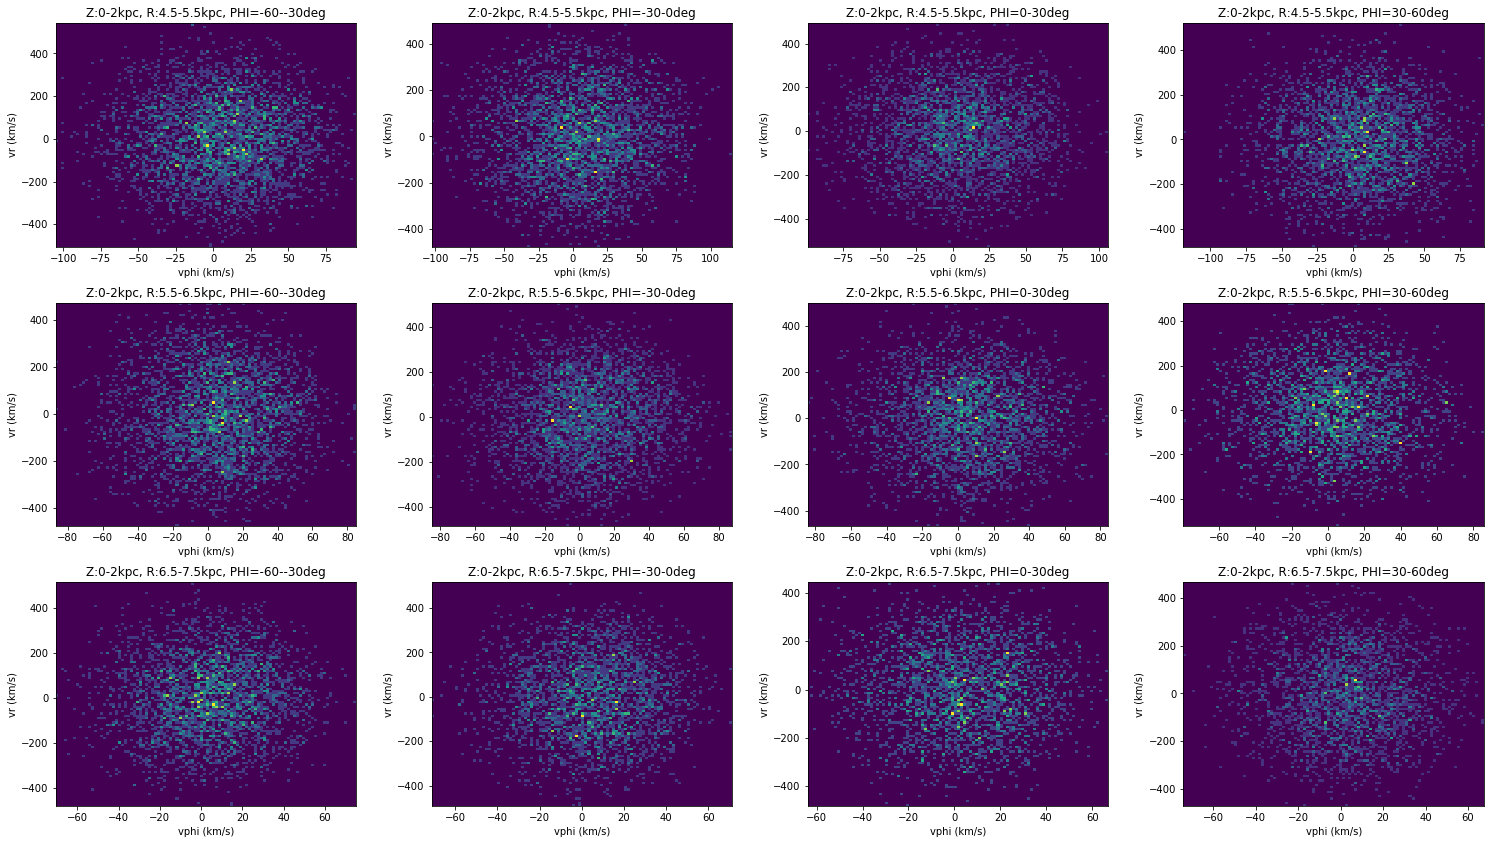

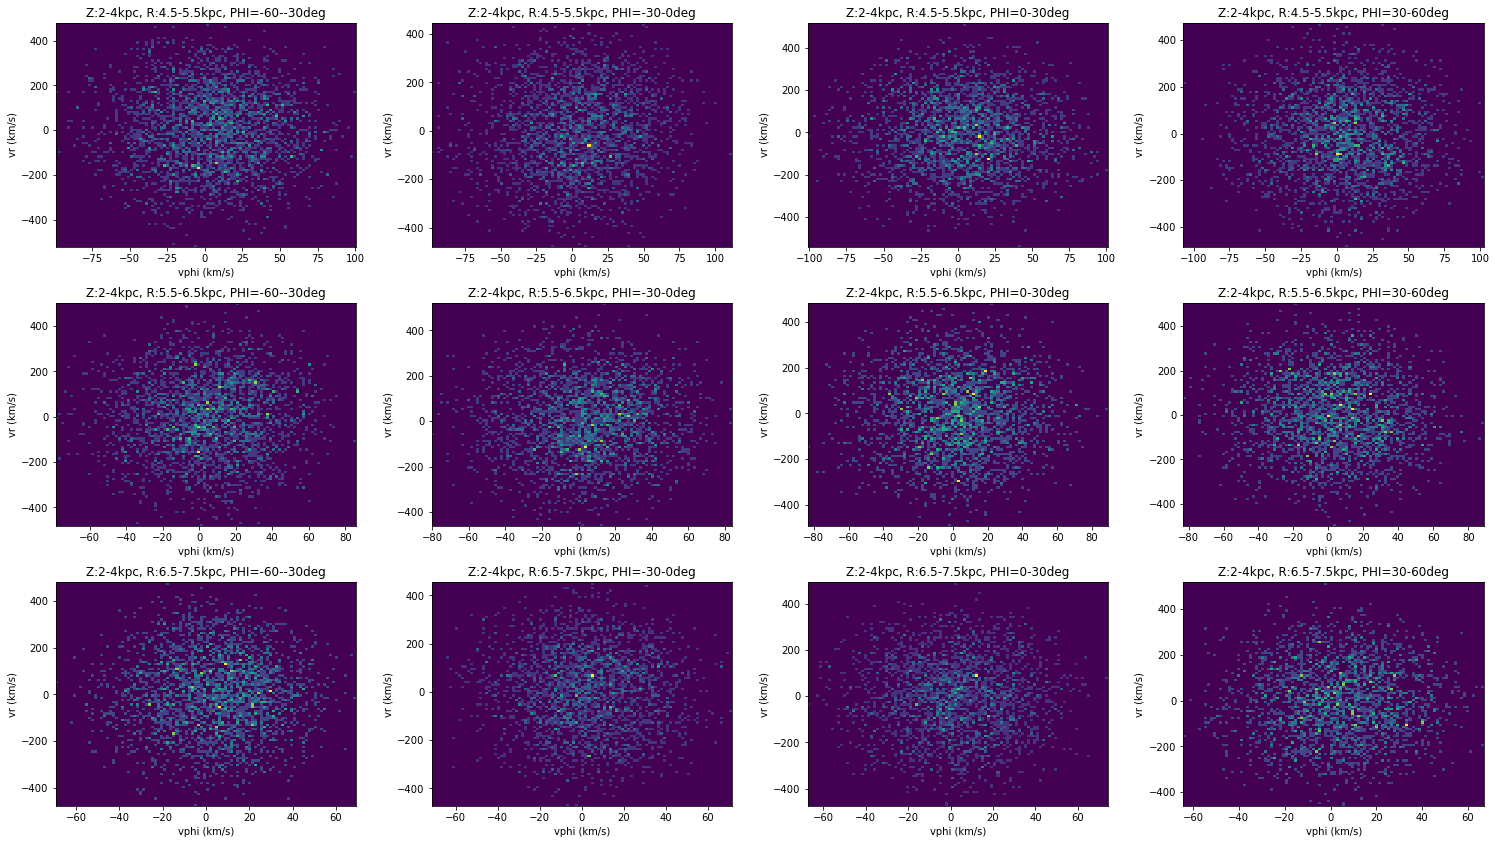

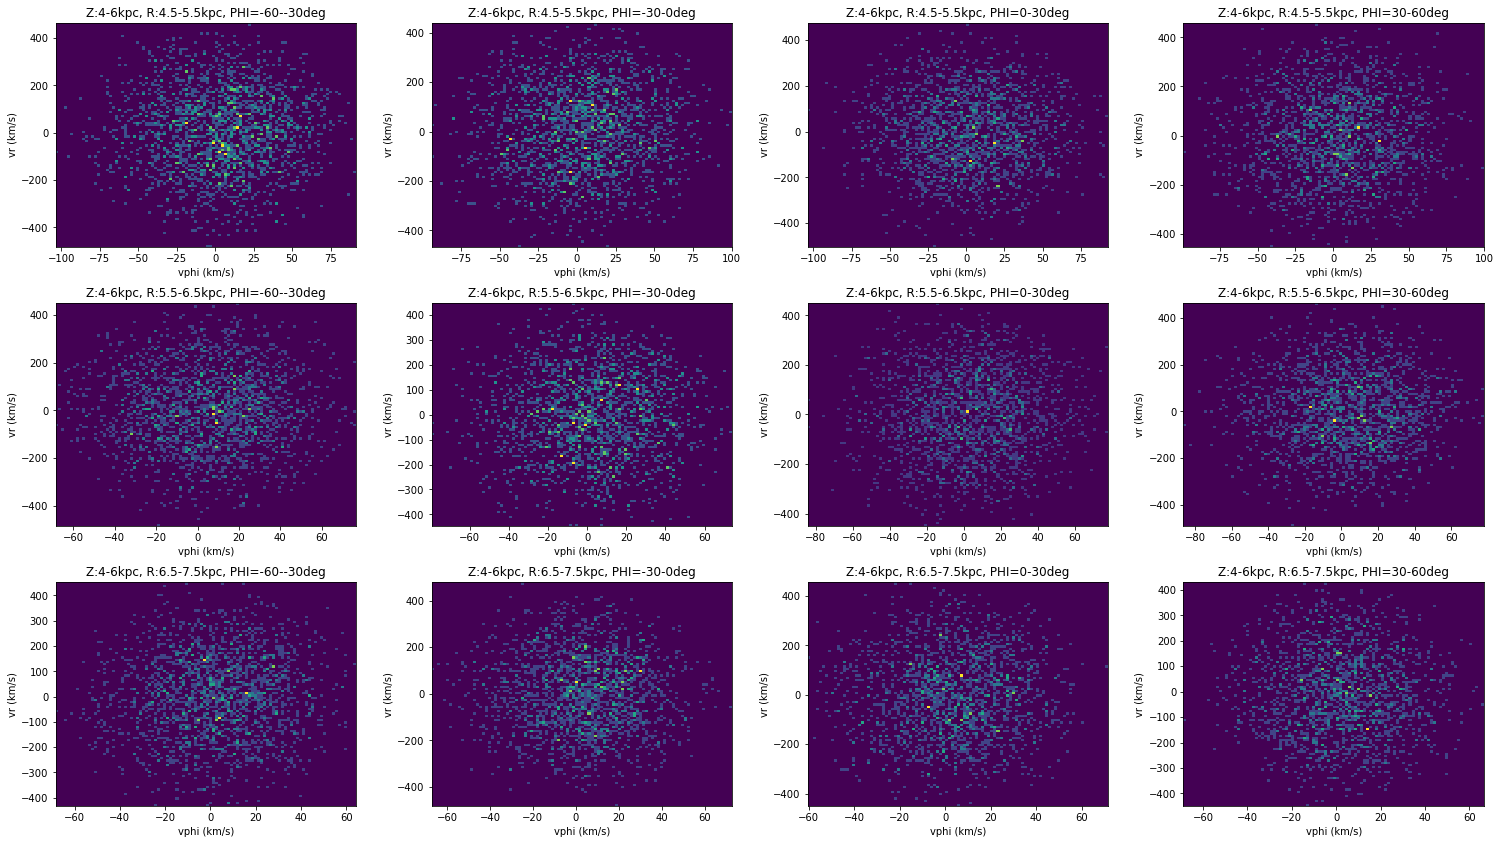

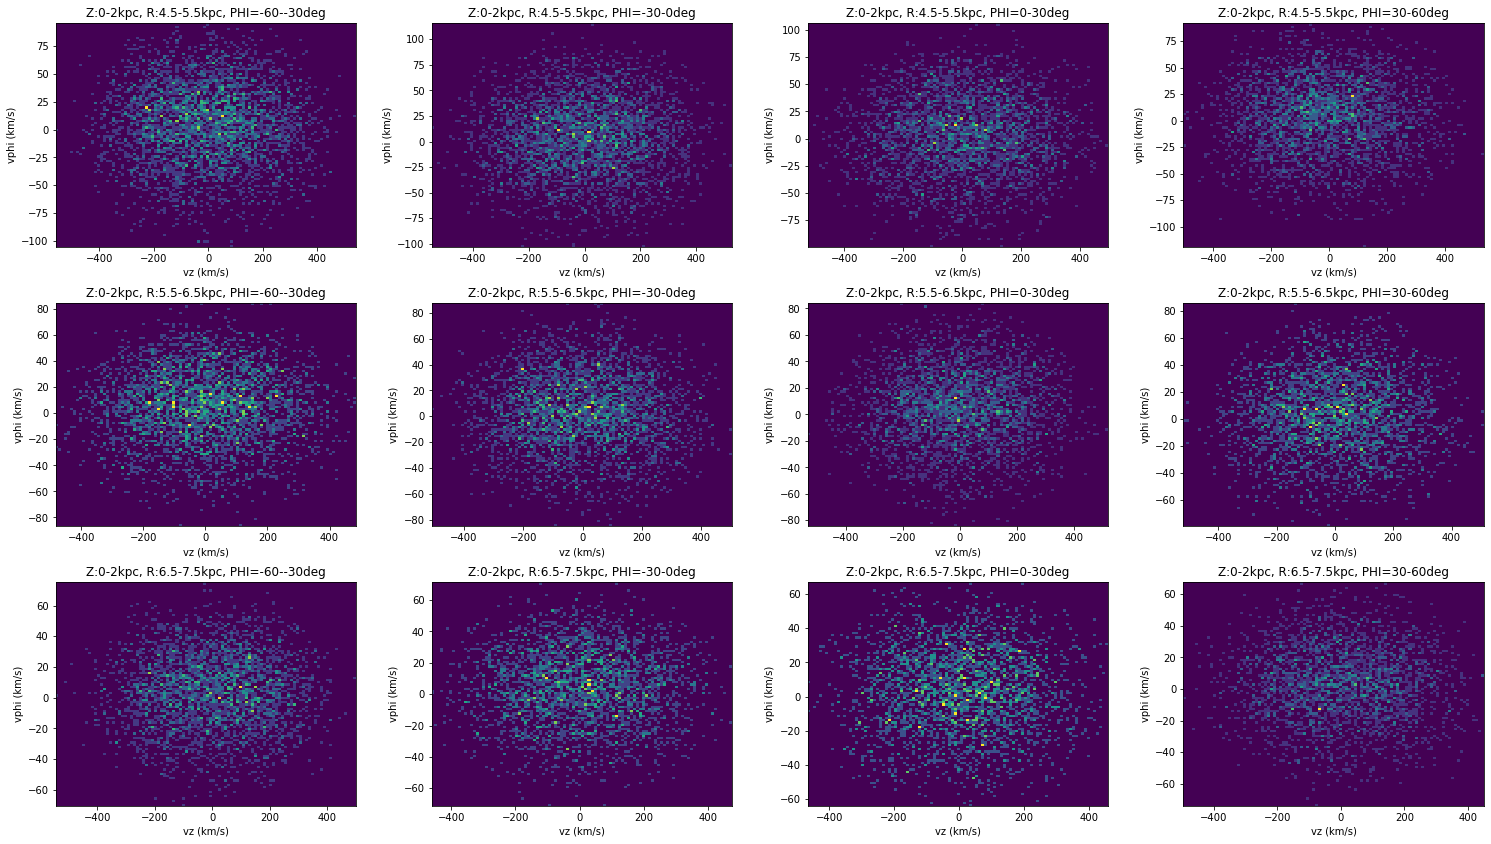

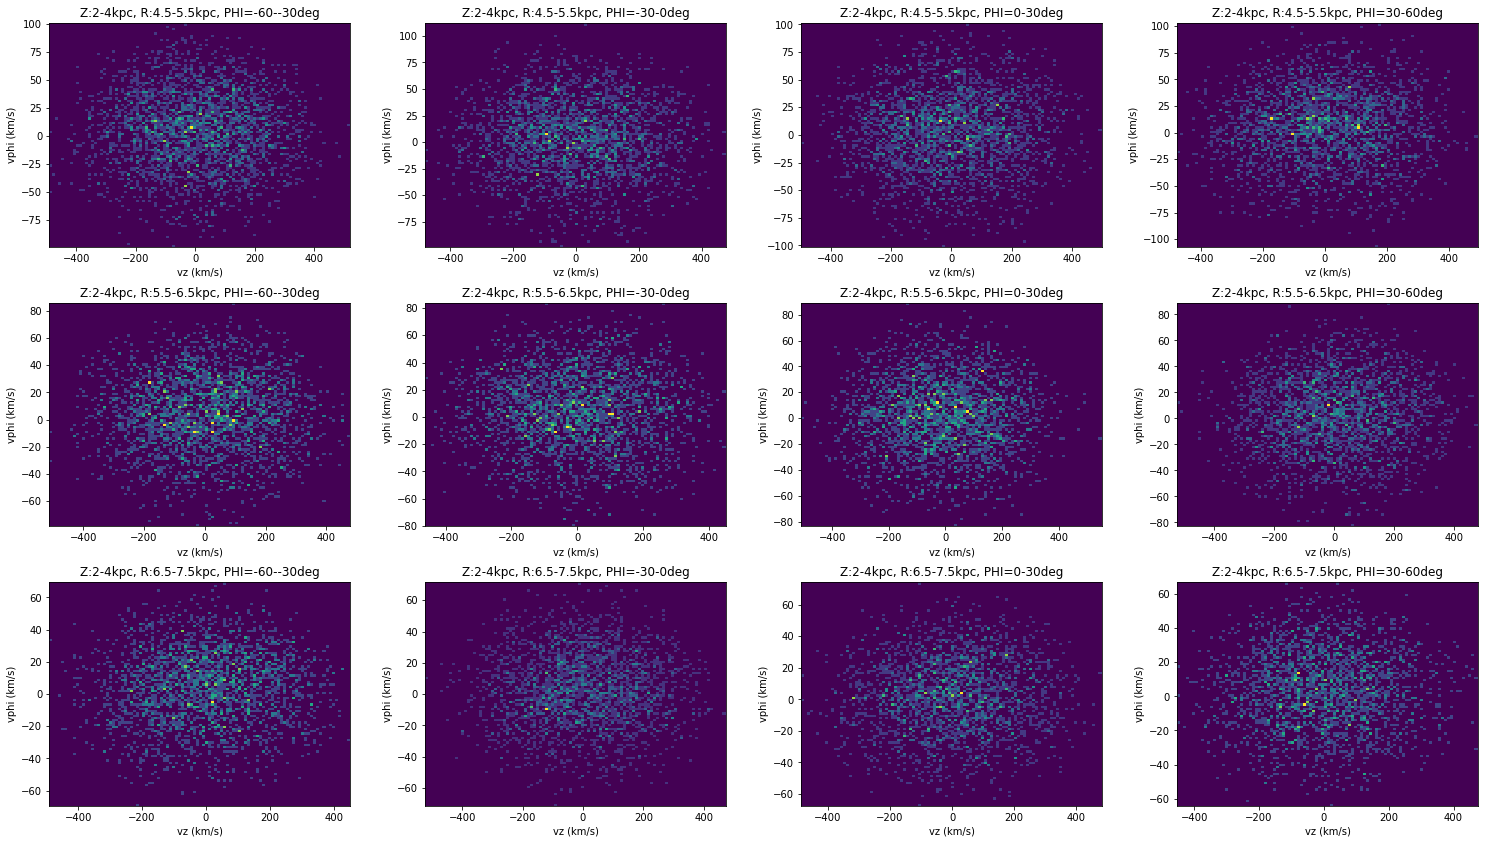

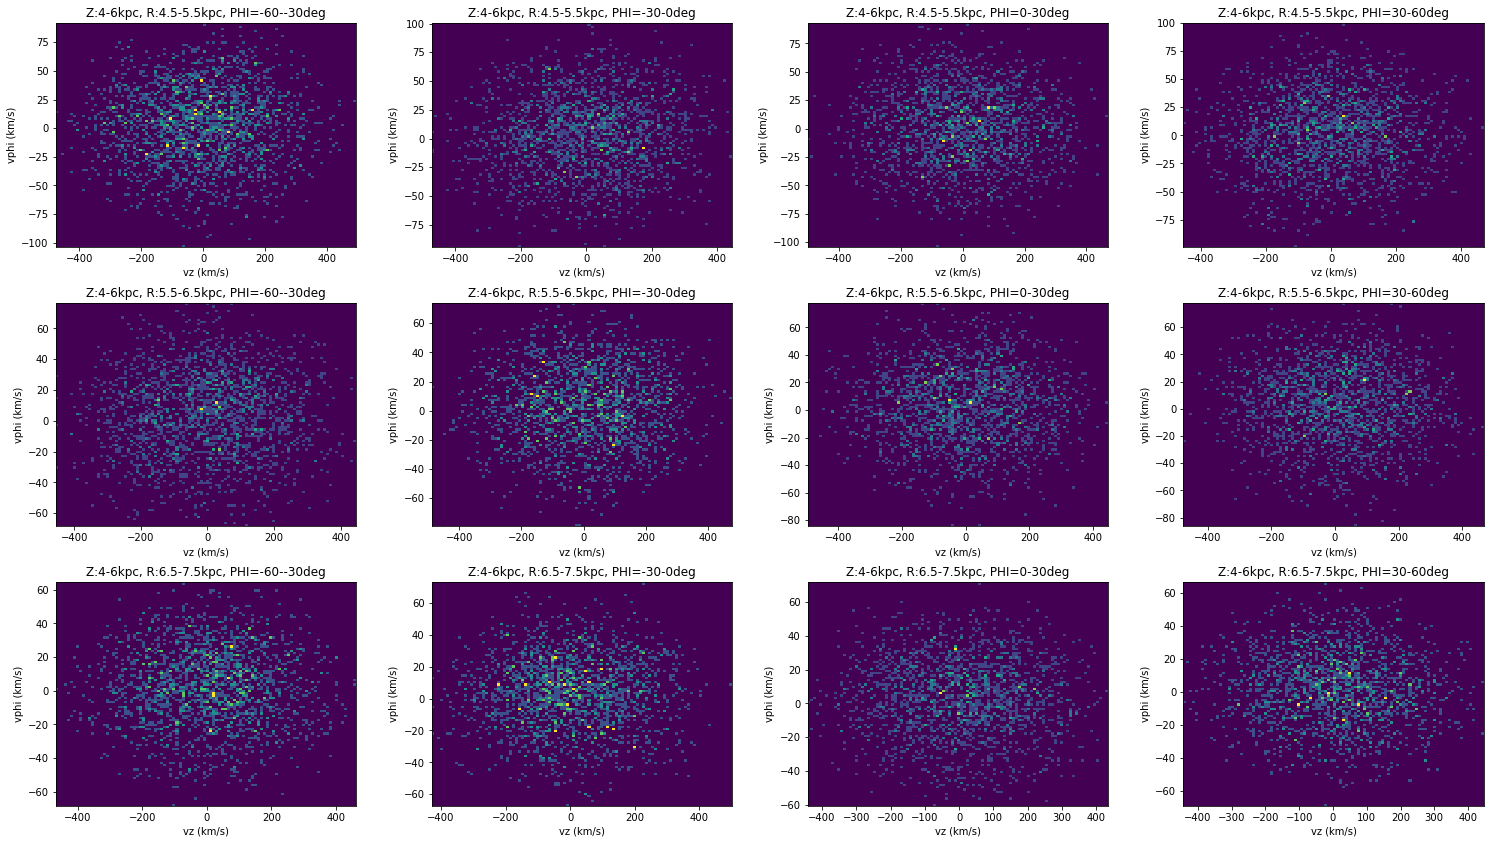

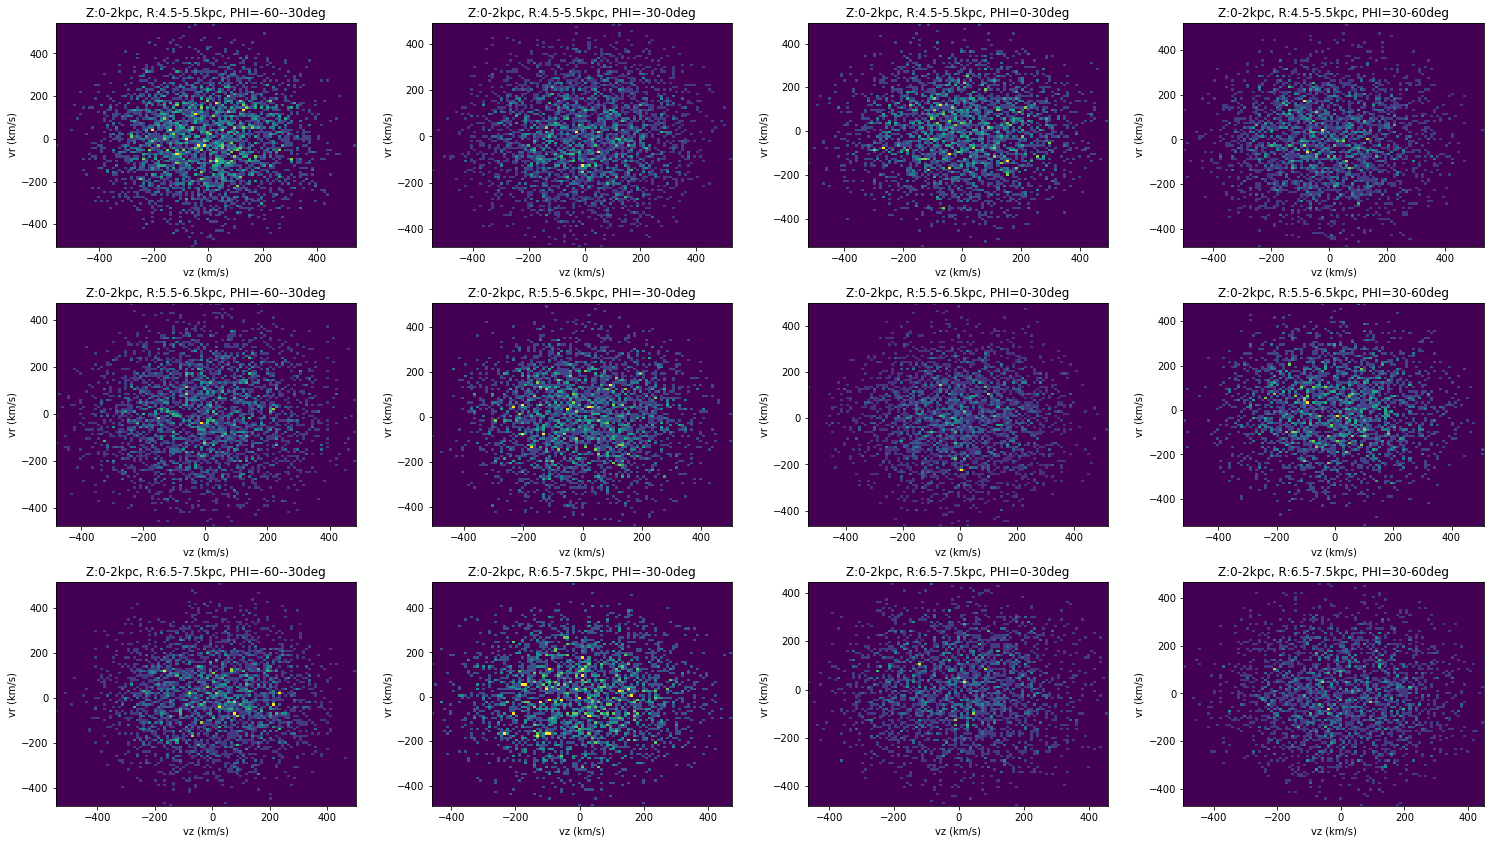

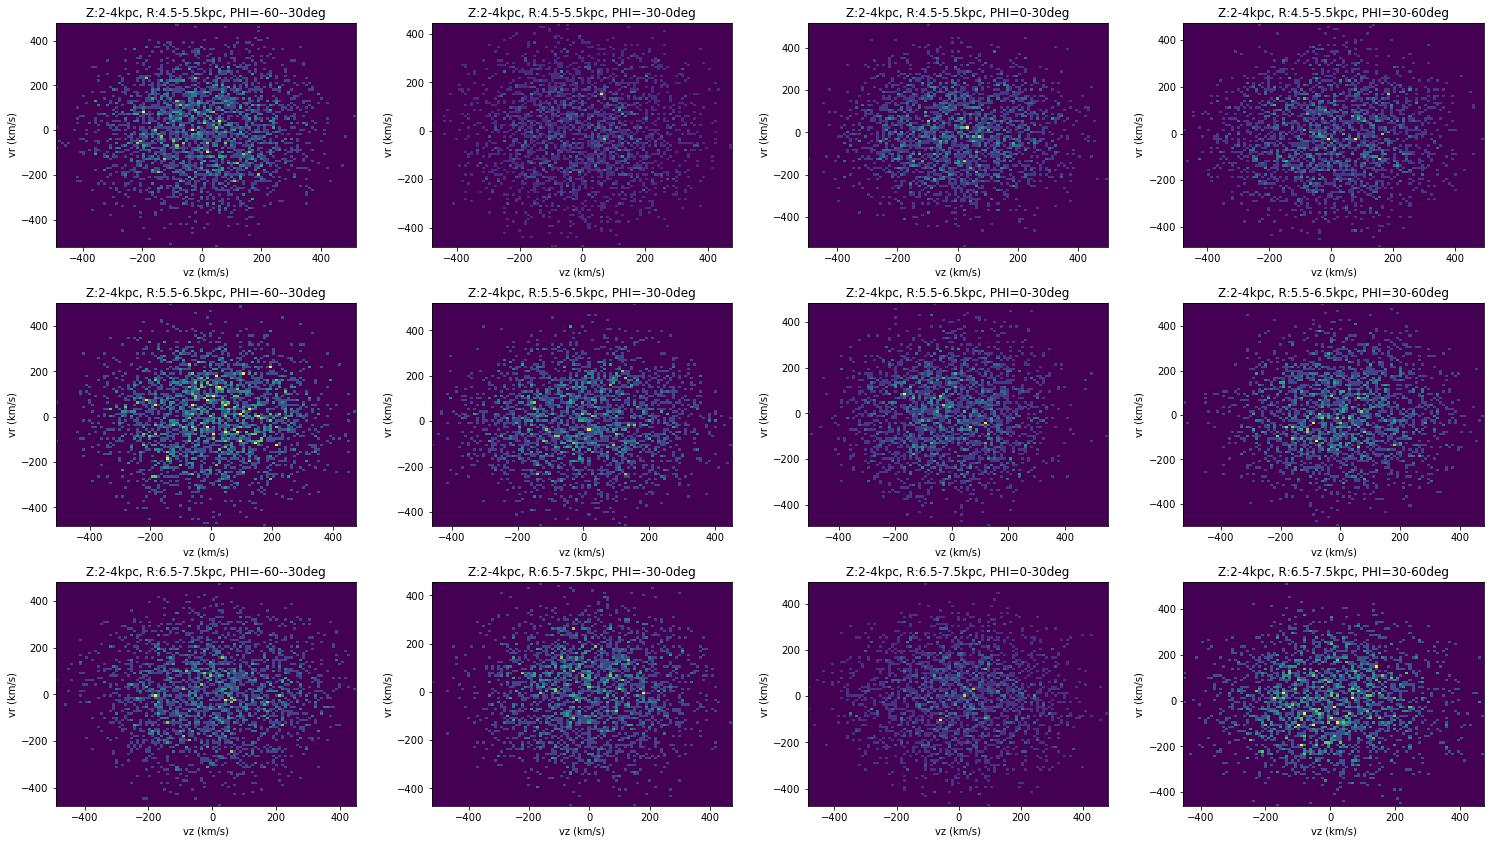

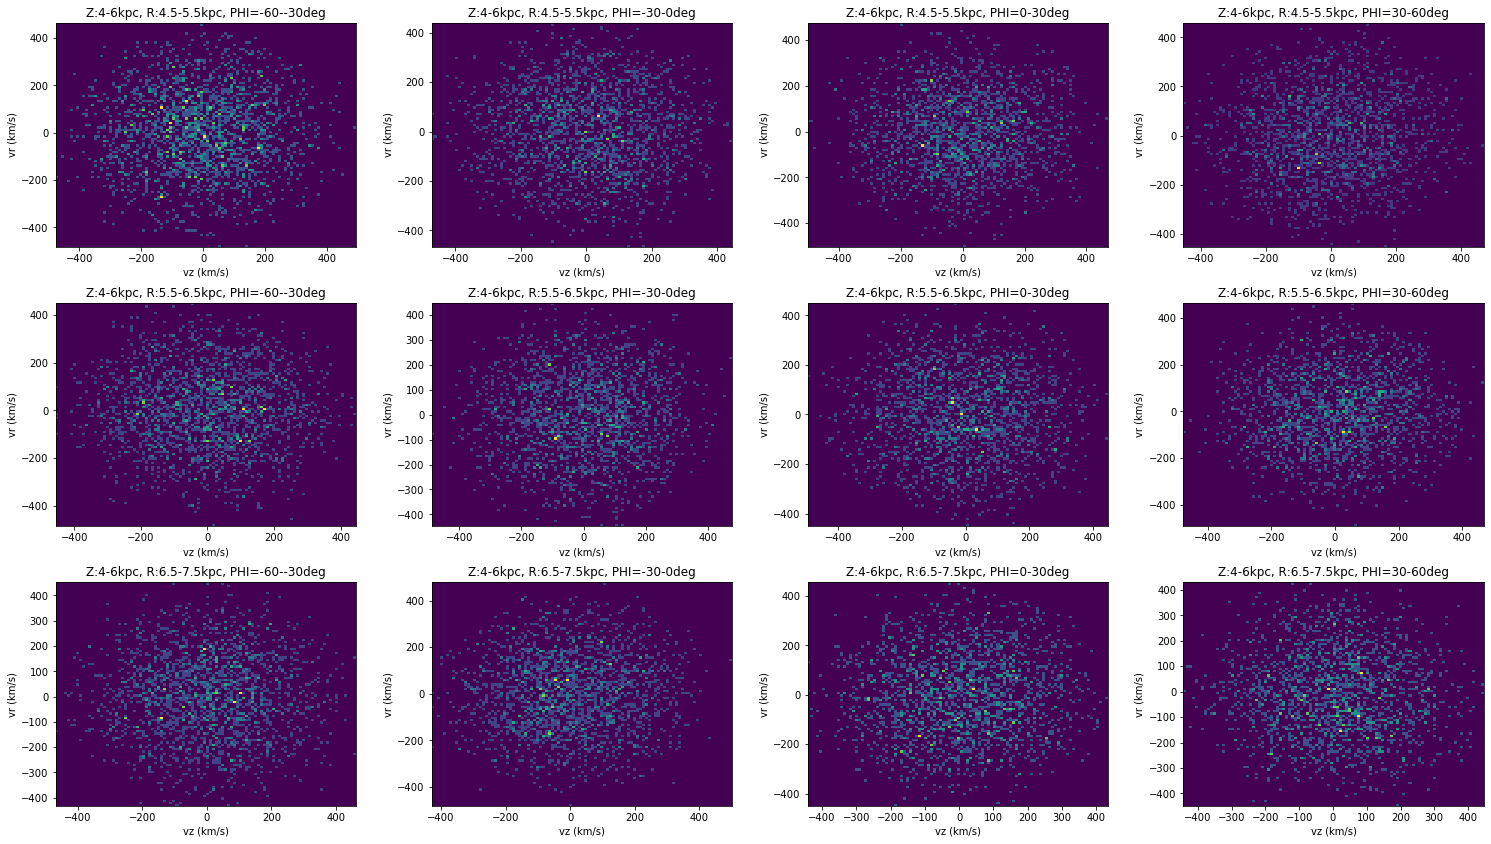

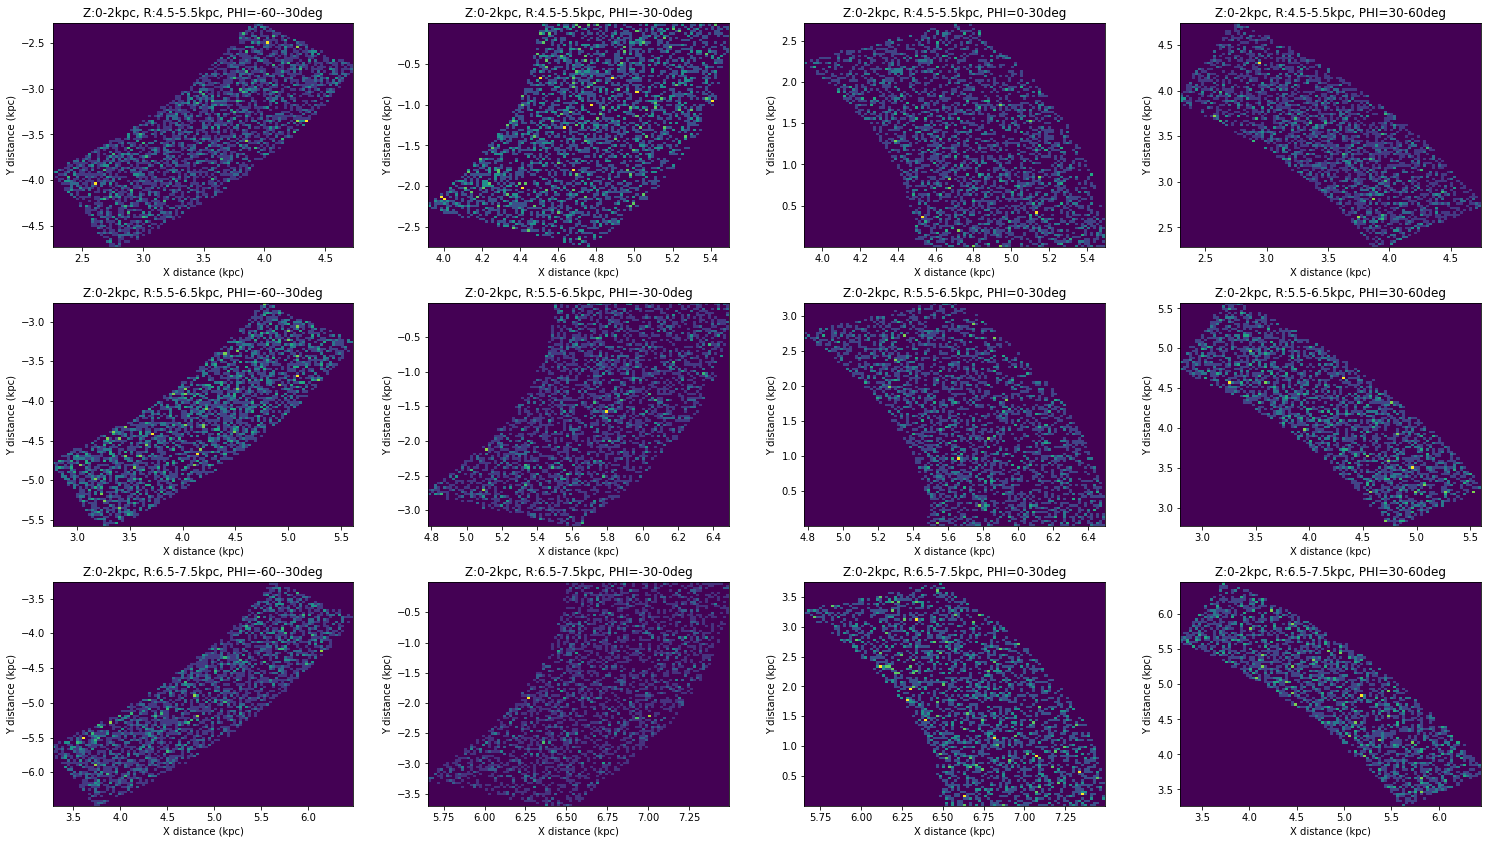

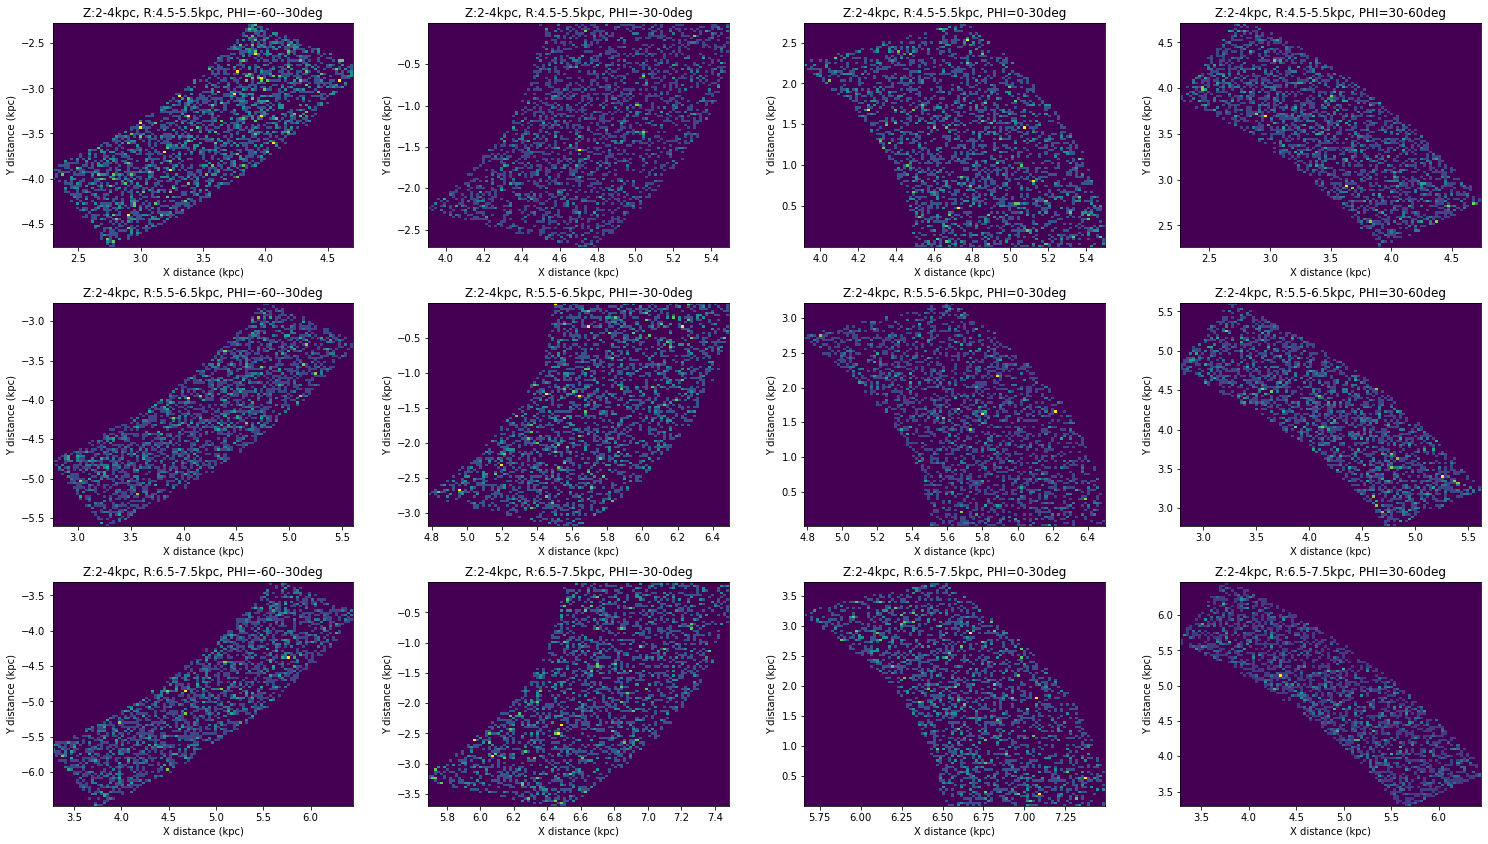

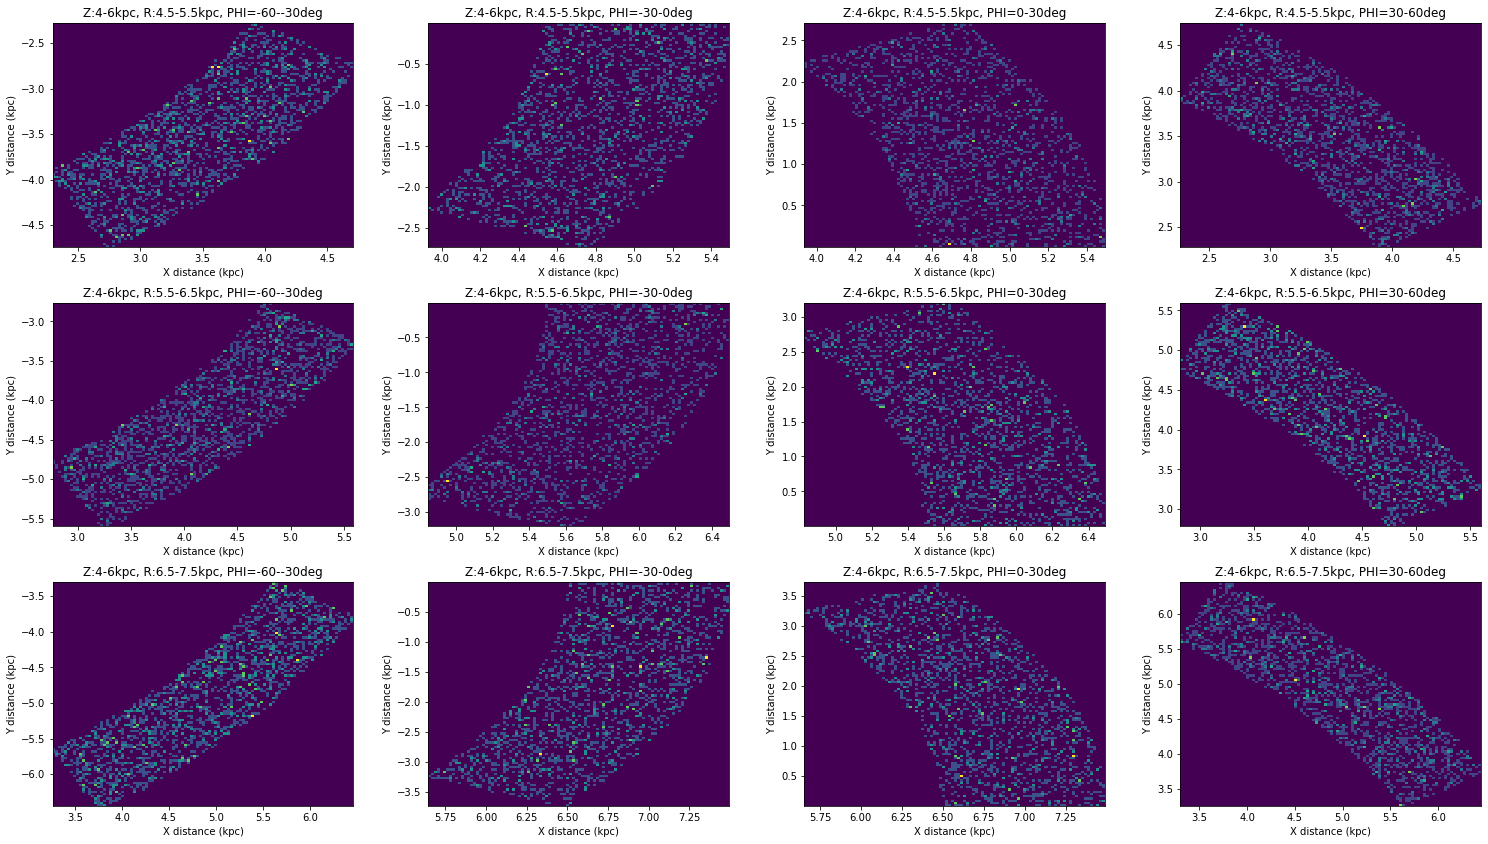

In [9]:
#generate multiplots of surface density and kinematics
for vels in ['vphi, vr', 'vz, vphi', 'vz, vr']:
    gen_plots(df, (0, 6, 2, "z"), (4.5, 7.5, 1, 'r'), (-60, 60, 30, 'phi'), path='analysis/multis/', vels=vels)
gen_plots(df, (0, 6, 2, "z"), (4.5, 7.5, 1, 'r'), (-60, 60, 30, 'phi'), path='analysis/multis/')

In [10]:
# example call
# plot_cuts((0,2), (5.5,6.5), (0,360), df, vels="vphi,vr")

## Elena's original plotting code:

In [11]:
if False:
    path = "data/snap_582.hdf5"
    head, df = read_hdf5(path, p_type=3) #testing with fewer particles
    df["x"] = df["x"] - df["x"].median()
    df["y"] = df["y"] - df["y"].median()
    mass = head["MassTable"][3]
    BINS_r, BINS_theta = 360,360
    BINS=512
    lengthX=15.0
    lengthY=15.0
    vx0=-5.0
    vy0=170.0
    Zmin=-4.25
    Zmax=-0.27
    rmin, rmax = 0., 15.
    dtheta=2*np.pi/BINS_theta
    dr=(rmax-rmin)/BINS_r
    thetamid=(np.arange(BINS_theta)+0.5) * dtheta - np.pi   
    rmid=(np.arange(BINS_r)+0.5) * dr + rmin

    px,py = df["x"], df["y"]
    r=np.sqrt(px**2. + py**2.) 
    theta=np.arctan2(py,px)
    h, x, y = np.histogram2d(r,theta,bins=[BINS_r,BINS_theta],range=[[rmin,rmax],[-np.pi,np.pi]])

    #divide by area to get surface density
    for i in range(0,BINS_r):
            h[i,:]/=rmid[i]*dr*dtheta

    #fit the axisymmetric surface density            
    meanh=np.zeros(BINS_r)
    for i in range(0,BINS_r):
            meanh[i]=h[i,:].mean()
    z=np.polyfit(rmid, np.log(meanh), 1)
    Rs=-1/z[0]
    p = np.poly1d(z)
    print( "Rs = ", Rs, mass )

    #calculate residuals
    for i in range(0,BINS_r):
            #h[i,:]=(h[i,:] - np.exp(p(rmid[i]))) / np.exp(p(rmid[i]))
            h[i,:]=(h[i,:] - h[i,:].mean()) / (h[i,:].mean())
    Z,x,y=np.histogram2d(px/Rs,py/Rs, range=[[-lengthX/Rs,lengthX/Rs],[-lengthY/Rs,lengthY/Rs]], bins=BINS, normed=True)

    Z=np.log10(Z)


    Zmin=Z[Z>-np.inf].min()
    Zmax=Z[Z<np.inf].max()
    if ((Zmax==0.0) & (Zmin==0.0)):
            Zmin=Z[Z>-np.inf].min()
            Zmax=Z.max()
    else:
            Z[Z<Zmin]=Zmin
            Z[Z>Zmax]=Zmax
    fig = plt.figure(1, figsize=(25.0,25.0))

    #left plot
    #ax = fig.add_subplot(1,2,1,title=tname+"  t="+str(round(head.time*co.UnitTime_in_Gyr*1000.0,1))+"Myr")

    ax = fig.add_subplot(1,2,1) #,title=tname+"  t="+str(round(myTime*co.UnitTime_in_Gyr*1000.0,1))+"Myr")
    im=ax.imshow(Z.T, vmin=Zmin, vmax=Zmax,
            origin='lower',interpolation='nearest',
            extent=[-lengthX/Rs,lengthX/Rs,-lengthY/Rs,lengthY/Rs],
            cmap=cm.get_cmap('viridis'))
    ax.set_xlabel('x/Rs', fontsize=18, fontweight='bold')
    ax.set_ylabel('y/Rs',fontsize=18, fontweight='bold')
    plt.xticks(np.arange(-round(lengthX/Rs), round(lengthX/Rs), step=2), fontsize=15, fontweight='bold')
    plt.yticks(np.arange(-round(lengthY/Rs), round(lengthY/Rs), step=2), fontsize=15, fontweight='bold')
    plt.colorbar(im, shrink=0.35)        